In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import pickle

In [ ]:
print(keras.__version__)

2.5.0


In [ ]:

raw_interactions = pd.read_csv('/content/drive/MyDrive/archive/RAW_interactions.csv')
raw_recipes = pd.read_csv('/content/drive/MyDrive/archive/RAW_recipes.csv')
raw_interactions = raw_interactions.dropna()
raw_interactions = raw_interactions[raw_interactions["rating"] !=0]
raw_interactions.shape

rating_count = (raw_interactions.
     groupby(by = ['recipe_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'RatingCount_recipe'})
     [['recipe_id', 'RatingCount_recipe']]
    )
rating_count1 = rating_count.query('RatingCount_recipe >= 5')

user_rating = pd.merge(rating_count1, raw_interactions, left_on='recipe_id', right_on='recipe_id', how='left')
user_count = (user_rating.
     groupby(by = ['user_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'RatingCount_user'})
     [['user_id', 'RatingCount_user']]
    )
user_count = user_count.query('RatingCount_user >=5')

combined = user_rating.merge(user_count, left_on = 'user_id', right_on = 'user_id', how = 'inner')

print('unique recipes: ', combined['recipe_id'].nunique())
print('Unique users: ', combined['user_id'].nunique())

unique recipes:  50676
Unique users:  18042


In [ ]:
rating_count1

,recipe_id,RatingCount_recipe
2,40,9
8,49,18
13,58,7
15,62,22
17,66,19
...,...,...
226409,533699,8
226449,534900,6
226497,535779,5
226519,536119,8


In [ ]:

inverse_recipes_raw_interactions= {val: i for i, val in enumerate(combined.recipe_id.unique())}
combined.recipe_id = combined.recipe_id.map(inverse_recipes_raw_interactions)
combined.sort_values(by='recipe_id', inplace=True)
combined.reset_index(inplace=True, drop=True)
inverse_users_raw_interactions = {val: i for i, val in enumerate(combined.user_id.unique())}
combined.user_id = combined.user_id.map(inverse_users_raw_interactions)
combined.sort_values(by='user_id', inplace=True)
combined.reset_index(inplace=True, drop=True)

In [ ]:

train, test = train_test_split(combined, test_size=0.3, random_state=0)

n_users, n_recipes= len(combined.user_id.unique()), len(combined.recipe_id.unique())

In [ ]:
print(n_users,n_recipes)
embedding_size = 16

18042 50676


In [ ]:
from keras.layers import Input, Dense, Dropout
recipe_input = layers.Input(shape=[1], name='Recipe')
user_input = layers.Input(shape=[1], name='User')

recipe_embedding = layers.Embedding(input_dim=n_recipes,
                                   input_length=1,
                                   output_dim=embedding_size,
                                   name='Recipe-Embedding')(recipe_input)
user_embedding = layers.Embedding(input_dim=n_users,
                                  input_length=1,
                                  output_dim=embedding_size,
                                  name='User-Embedding')(user_input)

recipe_vec = layers.Flatten()(recipe_embedding)
user_vec = layers.Flatten()(user_embedding)

input_vecs = layers.Concatenate()([user_vec, recipe_vec])


encoded = layers.Dense(64, activation='relu')(input_vecs)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded= Dropout(0.9, name='Dropout')(encoded) # Dropout
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)

decoded = layers.Dense(1, activation='relu')(decoded)
model = keras.Model(inputs=[user_input, recipe_input], outputs=decoded)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Recipe (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 16)        288672      User[0][0]                       
__________________________________________________________________________________________________
Recipe-Embedding (Embedding)    (None, 1, 16)        810816      Recipe[0][0]                     
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/autoencder_model1.png')

NameError: ignored

In [ ]:
epochs = 10

In [ ]:
import pickle
hist_json_file = '/content/drive/MyDrive/history_autoencoder_final.json' 
history1 = pd.DataFrame(History.history) 
# save to json:  
with open(hist_json_file, mode='w') as f:
    history1.to_json(f)

NameError: ignored

In [ ]:
history1.history

{'loss': [0.5333150029182434,
  0.3158858120441437,
  0.26876765489578247,
  0.20381252467632294,
  0.15249592065811157,
  0.11917801201343536,
  0.09736616909503937,
  0.08319386094808578,
  0.07360731810331345,
  0.06713832914829254],
 'val_loss': [0.6561963558197021,
  0.5744568109512329,
  0.5311769247055054,
  0.9776740074157715,
  1.0907129049301147,
  1.1310232877731323,
  1.3553599119186401,
  1.6270450353622437,
  1.4657894372940063,
  1.3474723100662231]}

In [ ]:
history1.model.save('/content/drive/MyDrive/model_autoencoder_final.h5')


In [ ]:
from keras.models import load_model
model_diploma1=load_model('/content/drive/MyDrive/model_autoencoder_final.h5')
model_diplom=load_model('/content/drive/MyDrive/autoencoder.h5')

In [ ]:
train

,recipe_id,RatingCount_recipe,user_id,date,rating,review,RatingCount_user
14851,18794,22,68,2006-10-16,5,"Very yummy! Chewy, crunchy oatmeal cookie with...",1633
341935,4473,66,3712,2007-12-03,4,My turned out way more brown than this picture...,73
155086,44224,8,1041,2010-02-20,3,"This was a great sauce, I did not use shrimp, ...",153
110238,2351,108,618,2009-05-31,5,Great recipe! DH bought hot and spicy taco se...,324
368543,22320,11,4274,2008-11-13,4,Worth trying. My broth wasn't as deep as that...,81
...,...,...,...,...,...,...,...
359783,2835,6,4015,2009-02-06,5,"Great flavor, fast & easy! I seasoned my chic...",228
152315,11966,181,1019,2006-03-22,4,The taste of the carrots were good and it is e...,42
117952,21942,22,706,2005-08-08,4,These were great! I made them last night and...,532
435829,12003,6,6786,2009-03-10,3,I was slightly disappointed with this marinade...,120


In [ ]:
test_preds

array([[4.4153743],
       [2.7818422],
       [3.2523348],
       ...,
       [1.530821 ],
       [4.3232856],
       [2.419536 ]], dtype=float32)

In [ ]:
test_preds = model_diploma1.predict([test.user_id, test.recipe_id])

In [ ]:
test_preds[4]

array([4.42628], dtype=float32)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mean_squared_error(test.rating,test_preds)


1.3403253815663967

In [ ]:

raw_interactions = pd.read_csv('/content/drive/MyDrive/archive/RAW_interactions.csv')
raw_recipes = pd.read_csv('/content/drive/MyDrive/archive/RAW_recipes.csv')
raw_interactions = raw_interactions.dropna()
raw_interactions = raw_interactions[raw_interactions["rating"] !=0]
raw_interactions.shape

rating_count = (raw_interactions.
     groupby(by = ['recipe_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'RatingCount_recipe'})
     [['recipe_id', 'RatingCount_recipe']]
    )
rating_count1 = rating_count.query('RatingCount_recipe >= 5')


user_rating = pd.merge(rating_count1, raw_interactions, left_on='recipe_id', right_on='recipe_id', how='left')
user_count = (user_rating.
     groupby(by = ['user_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'RatingCount_user'})
     [['user_id', 'RatingCount_user']]
    )
user_count = user_count.query('RatingCount_user >=5')

combined_df= user_rating.merge(user_count, left_on = 'user_id', right_on = 'user_id', how = 'inner')
combined_df= combined_df.merge(raw_recipes, left_on = 'recipe_id', right_on = 'id', how = 'inner')

print('unique recipes: ', combined_df['recipe_id'].nunique())
print('Unique users: ', combined_df['user_id'].nunique())

unique recipes:  50676
Unique users:  18042


In [ ]:

inverse_recipes_raw_interactions= {val: i for i, val in enumerate(combined_df.recipe_id.unique())}
combined_df.recipe_id = combined_df.recipe_id.map(inverse_recipes_raw_interactions)
combined_df.sort_values(by='recipe_id', inplace=True)
combined_df.reset_index(inplace=True, drop=True)
inverse_users_raw_interactions = {val: i for i, val in enumerate(combined_df.user_id.unique())}
combined_df.user_id = combined_df.user_id.map(inverse_users_raw_interactions)
combined_df.sort_values(by='user_id', inplace=True)
combined_df.reset_index(inplace=True, drop=True)

In [ ]:
test_preds = model.predict([test.user_id, test.recipe_id])


In [ ]:
test_preds.shape

(171990, 1)

array([4.342291], dtype=float32)

In [ ]:
test

186907    False
262609    False
501088    False
471809    False
410153    False
          ...  
189252    False
172600    False
91542     False
522894    False
223079    False
Name: user_id, Length: 171990, dtype: bool

In [ ]:
rated_recipes = list(combined_df[combined_df['user_id'] == 10]['recipe_id'])

In [ ]:
rated_recipes

[5035,
 4442,
 17722,
 25253,
 40920,
 40921,
 14928,
 26236,
 39805,
 1067,
 1712,
 10657,
 2]

In [ ]:
recipe_ids = list(filter(lambda x: x not in rated_recipes, combined_df.recipe_id))

In [ ]:
len(recipe_ids)

572994

In [ ]:
 print("Usuário " + str(10) + " assistiu " + str(len(rated_recipes)) + " filmes. " +
          "Calculando ratings para outros " + str(len(recipe_ids)) + " filmes.")

Usuário 10 assistiu 13 filmes. Calculando ratings para outros 572994 filmes.


In [ ]:
recipe_ids = np.array(recipe_ids)
user = np.zeros_like(recipe_ids)
user[:] = 10



In [ ]:
rating_preds = model.predict([user, recipe_ids])


In [ ]:
recipe_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
rec_items = recipe_ids[:10]

In [ ]:
rec_items=[(str(combined_df['recipe_id'][recipe]), combined_df['name'][recipe],
             rating_preds[recipe][0]) for recipe in rec_items]

In [ ]:
rec_items

[('20039', 'ham and  cheddar macaroni salad', 4.9314637),
 ('18720', 'macaroni   cheese deluxe', 4.9314637),
 ('1447', 'balsamic and brown sugar roasted carrots', 4.9314637),
 ('7101', 'kittencal s taco seasoning mix', 4.9314637),
 ('35999', 'clear spinach and tomato soup ww friendly core', 4.9314637),
 ('26420', 'key lime pie martini', 4.9314637),
 ('24471', 'glazed soft pumpkin cookies', 4.9314637),
 ('5987', 'slow simmered spaghetti sauce', 4.9314637),
 ('2213',
  'tsr version of t g i  friday s black bean soup by todd wilbur',
  4.928758),
 ('7659', 'green beans from a can that don t taste like it', 4.928758)]

In [ ]:
test_preds.shape

(171990, 1)

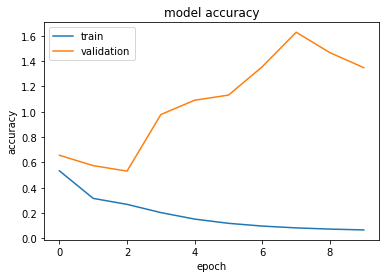

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()